In [1]:
# Import libraries
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
data_dir = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data'  

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


Found 17353 files belonging to 2 classes.
Train samples:      1068     batches(13) ==> 13884
Validation samples: 200       batches(13) ==> 2600
Test samples:       67      batches(13) ==> 871


In [4]:


def model():
    # Load the base model with MobileNet
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
model = model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,280,514 (16.33 MB)

 Trainable params: 3,989,506 (15.22 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [ ]:

# Train the model
history_V = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=13,
    epochs=7
)


Epoch 1/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 967s 880ms/step - accuracy: 0.6303 - loss: 0.6878 - precision: 0.6303 - recall: 0.6303 - val_accuracy: 0.7414 - val_loss: 0.5027 - val_precision: 0.7414 - val_recall: 0.7414
Epoch 2/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 993s 949ms/step - accuracy: 0.7608 - loss: 0.4850 - precision: 0.7608 - recall: 0.7608 - val_accuracy: 0.7869 - val_loss: 0.4539 - val_precision: 0.7869 - val_recall: 0.7869
Epoch 3/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1392s 1s/step - accuracy: 0.8328 - loss: 0.3700 - precision: 0.8328 - recall: 0.8328 - val_accuracy: 0.7622 - val_loss: 0.5413 - val_precision: 0.7622 - val_recall: 0.7622
Epoch 4/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 27072s 26s/step - accuracy: 0.8883 - loss: 0.2664 - precision: 0.8883 - recall: 0.8883 - val_accuracy: 0.8524 - val_loss: 0.3709 - val_precision: 0.8524 - val_recall: 0.8524
Epoch 5/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 941s 900ms/step - accuracy: 0.9202 - loss: 0.1957 - precision: 0.9202 - recall: 0.9202 - val_accuracy

In [ ]:
model.save("trained_model/MobileNet.keras")

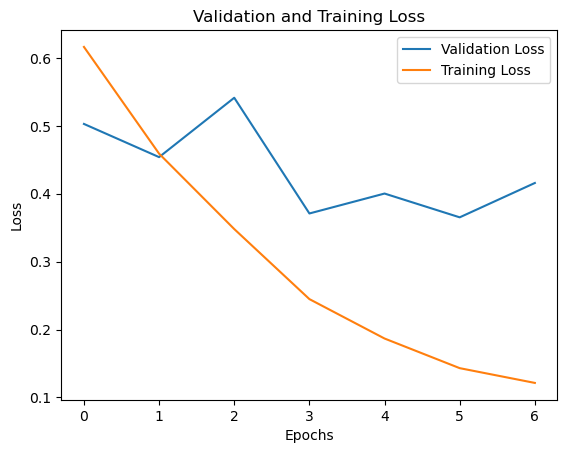

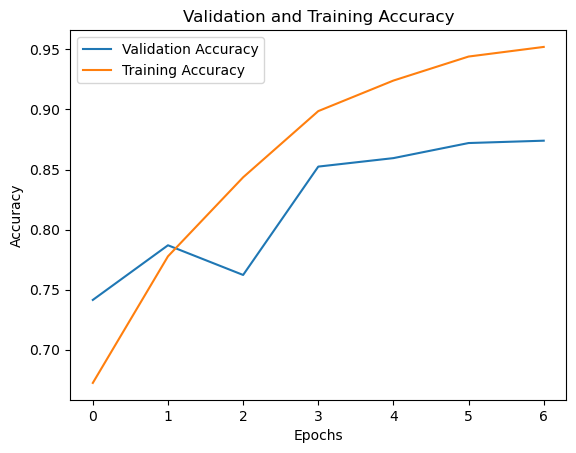

In [ ]:
# Plot the validation loss
plt.plot(history_V.history['val_loss'], label='Validation Loss')
plt.plot(history_V.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_V.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_V.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
